### 1. Initializations and Dataset Download

In [ ]:
! pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Skipping, found downloaded files in ".\animal-faces" (use force=True to force download)



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\ACER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


### 2. Imports

In [1]:
import torch # Main PyTorch Library
from torch import nn # Used for creating the layers and loss function
from torch.optim import Adam # Adam Optimizer
import torchvision.transforms as transforms # Transform function used to modify and preprocess all the images
from torch.utils.data import Dataset, DataLoader # Dataset class and DataLoader for creating the objects
from sklearn.preprocessing import LabelEncoder # Label Encoder to encode the classes from strings to numbers
import matplotlib.pyplot as plt # Used for visualizing the images and plotting the training progress
from PIL import Image # Used to read the images from the directory
import pandas as pd # Used to read/create dataframes (csv) and process tabular data
import numpy as np # preprocessing and numerical/mathematical operations
import os # Used to read the images path from the directory

device = "cuda" if torch.cuda.is_available() else "cpu" # detect the GPU if any, if not use CPU, change cuda to mps if you have a mac
print("Device available: ", device)

Device available:  cuda


### 3. Reading Data Paths

In [2]:
image_path =[]
labels = []
for i in os.listdir("D:/NCKH/Demo/animal-faces/afhq"):
    for label in os.listdir(f"D:/NCKH/Demo/animal-faces/afhq/{i}"):
        for image in os.listdir(f"D:/NCKH/Demo/animal-faces/afhq/{i}/{label}"):
            image_path.append(f"D:/NCKH/Demo/animal-faces/afhq/{i}/{label}/{image}")
            labels.append(label)
data_df = pd.DataFrame(zip(image_path, labels),columns = ["image_path","labels"])
print(data_df["labels"].unique())
data_df.head()            

['cat' 'dog' 'wild']


,image_path,labels
0,D:/NCKH/Demo/animal-faces/afhq/train/cat/flick...,cat
1,D:/NCKH/Demo/animal-faces/afhq/train/cat/flick...,cat
2,D:/NCKH/Demo/animal-faces/afhq/train/cat/flick...,cat
3,D:/NCKH/Demo/animal-faces/afhq/train/cat/flick...,cat
4,D:/NCKH/Demo/animal-faces/afhq/train/cat/flick...,cat


### 4. Data Split

In [21]:
train = data_df.sample(frac=0.7)    #70%
test = data_df.drop(train.index)    #30% tạm thời

val = test.sample(frac=0.5)         #15%
test = test.drop(val.index)         #15%
train.shape , test.shape, val.shape

((11291, 2), (2419, 2), (2420, 2))

### 5. Preprocessing Objects

In [3]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"]) #đổi cat = 0 dog = 1 wild = 2

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])


### 6. Custom Dataset Class

In [23]:
class CustomImageDataset(Dataset):
    def __init__(self,dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)
        
    def __len__(self):
        return self.dataframe.shape[0]
    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index,0]
        label = self.labels[index]
        
        image =Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image).to(device)
        return image,label

### 7. Create Dataset Objects

In [24]:
train_dataset = CustomImageDataset(dataframe = train,transform=transform)
val_dataset = CustomImageDataset(dataframe = val,transform=transform)
test_dataset = CustomImageDataset(dataframe = test,transform=transform)

### 8. Visualize Images

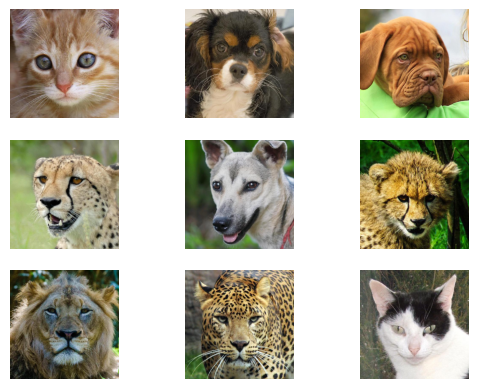

In [25]:
n_rows = 3
n_cols = 3
f,axarr = plt.subplots(n_rows,n_cols)
for row in range(n_rows):
    for col in range(n_cols):
        image = Image.open(data_df.sample(n = 1)["image_path"].iloc[0]).convert("RGB")
        axarr[row,col].imshow(image)
        axarr[row,col].axis('off')
plt.show()

### 9. Hyperparameters

In [ ]:
LR = 1e-4 
BATCH_SIZE = 16 #batch: mỗi lần lấy 16 ảnh       #shuffle xáo ảnh mỗi epochs
EPOCHS = 25

### 10. DataLoaders

In [27]:
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

### 11. Model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # ===== CNN LAYERS =====
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)    # Conv layer 1
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)   # Conv layer 2  
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Conv layer 3

        self.pooling = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.relu = nn.ReLU()              # Activation function
        
        # ===== FULLY CONNECTED LAYERS =====
        self.flatten = nn.Flatten()
        self.linear = nn.Linear((128 * 16 * 16), 128)  # Hidden layer
        self.output = nn.Linear(128, 3)                 # Output layer (3 classes)

    def forward(self, x):
        # ===== CNN FEATURE EXTRACTION =====
        x = self.conv1(x)    # Conv1: (3,128,128) → (32,128,128)
        x = self.pooling(x)  # Pool:  (32,128,128) → (32,64,64)
        x = self.relu(x)     # ReLU activation
        
        x = self.conv2(x)    # Conv2: (32,64,64) → (64,64,64)
        x = self.pooling(x)  # Pool:  (64,64,64) → (64,32,32)
        x = self.relu(x)     # ReLU activation
        
        x = self.conv3(x)    # Conv3: (64,32,32) → (128,32,32)
        x = self.pooling(x)  # Pool:  (128,32,32) → (128,16,16)
        x = self.relu(x)     # ReLU activation
        
        # ===== CLASSIFICATION HEAD =====
        x = self.flatten(x)  # Flatten: (128,16,16) → (32768,)
        x = self.linear(x)   # Dense: (32768,) → (128,)
        x = self.output(x)   # Output: (128,) → (3,)
        return x

In [29]:
model = Net().to(device)

### 12. Model Summary

In [30]:
from torchsummary import summary
summary(model, input_size=(3,128,128)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          18,496
         MaxPool2d-5           [-1, 64, 32, 32]               0
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 32, 32]          73,856
         MaxPool2d-8          [-1, 128, 16, 16]               0
              ReLU-9          [-1, 128, 16, 16]               0
          Flatten-10                [-1, 32768]               0
           Linear-11                  [-1, 128]       4,194,432
           Linear-12                    [-1, 3]             387
Total params: 4,288,067
Trainable params: 4,288,067
Non-trainable params: 0
---------------------------

### 13. Loss and Optimizer

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(),lr = LR)

### 14. Training

In [32]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
    total_acc_train = 0
    total_acc_val = 0
    total_loss_train = 0
    total_loss_val = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()
        
        train_loss.backward()
        
        train_acc = (torch.argmax(outputs, axis = 1)==labels).sum().item()

        total_acc_train += train_acc
        optimizer.step()
        
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            
            total_loss_val += val_loss.item()
            val_acc = (torch.argmax(outputs, axis = 1)==labels).sum().item()
            total_acc_val +=val_acc
    total_loss_train_plot.append(round(total_loss_train/1000,4))
    total_loss_validation_plot.append(round(total_loss_val/1000,4))
    
        
    total_acc_train_plot.append(round((total_acc_train/train_dataset.__len__())*100,4))
    total_acc_validation_plot.append(round((total_acc_val/val_dataset.__len__())*100,4))
    print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}''')
    print("="*25)

Epoch 1/25, Train Loss: 3.2532 Train Accuracy 81.0911
              Validation Loss: 0.3405 Validation Accuracy: 91.9421
Epoch 2/25, Train Loss: 1.4033 Train Accuracy 92.8084
              Validation Loss: 0.2546 Validation Accuracy: 93.5124
Epoch 3/25, Train Loss: 0.9623 Train Accuracy 95.2529
              Validation Loss: 0.194 Validation Accuracy: 95.4545
Epoch 4/25, Train Loss: 0.6834 Train Accuracy 96.8382
              Validation Loss: 0.1855 Validation Accuracy: 95.2066
Epoch 5/25, Train Loss: 0.5353 Train Accuracy 97.0685
              Validation Loss: 0.2248 Validation Accuracy: 94.6694
Epoch 6/25, Train Loss: 0.3874 Train Accuracy 98.1667
              Validation Loss: 0.1978 Validation Accuracy: 95.3719
Epoch 7/25, Train Loss: 0.2995 Train Accuracy 98.6007
              Validation Loss: 0.1957 Validation Accuracy: 95.8264
Epoch 8/25, Train Loss: 0.2194 Train Accuracy 99.0523
              Validation Loss: 0.2541 Validation Accuracy: 95.2066
Epoch 9/25, Train Loss: 0.1391 Tr

### 15. Testing


In [33]:
model.eval()  
total_loss_test = 0
total_acc_test = 0

with torch.inference_mode():  
    for inputs, labels in test_loader:
        # inputs, labels = inputs.to(device), labels.to(device)
        predictions = model(inputs)
        loss = criterion(predictions, labels)
        total_loss_test += loss.item()

        # Accuracy cho bài toán classification
        preds = torch.argmax(predictions, dim=1)
        total_acc_test += (preds == labels).sum().item()

avg_test_loss = total_loss_test / len(test_loader)
accuracy = total_acc_test / len(test_dataset) * 100

print(f"Accuracy Score is: {accuracy:.4f}% and Loss is {avg_test_loss:.4f}")
     

Accuracy Score is: 96.7342% and Loss is 0.1356


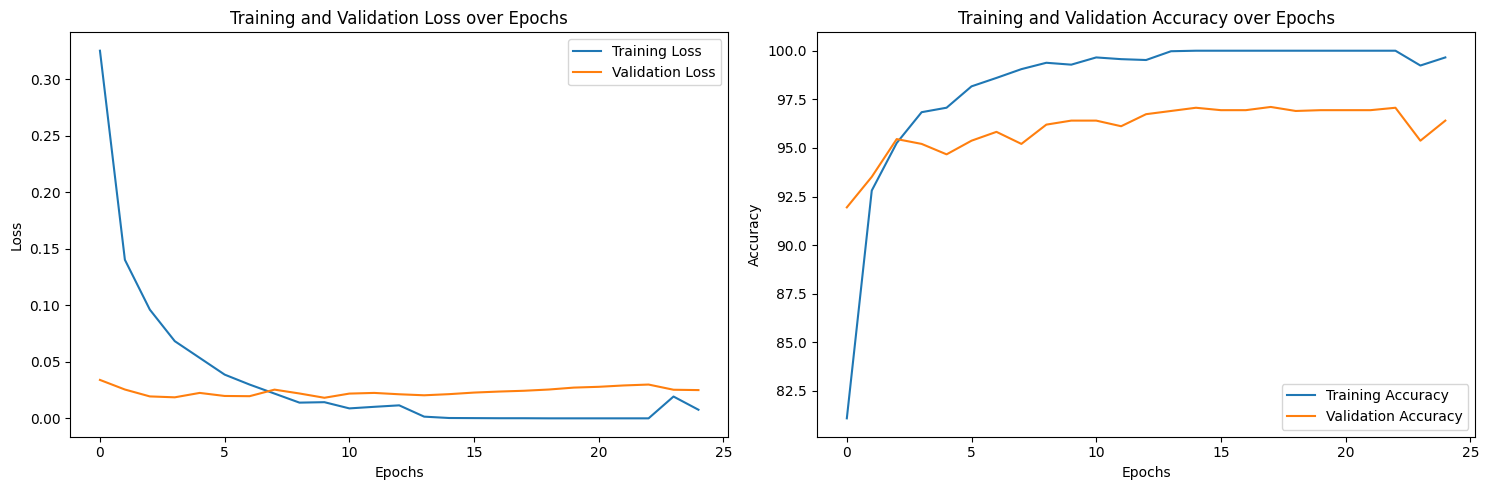

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()
     

In [35]:
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).to(device)
    print(image.shape)
    output = model(image.unsqueeze(0))
    output = torch.argmax(output, dim=1).item()
    return label_encoder.inverse_transform([output])

In [51]:
predict_image("D:/NCKH/Demo/bulldog.jpg")

torch.Size([3, 128, 128])


array(['wild'], dtype=object)

In [6]:
from pathlib import Path
# 1. Create models directory 
MODEL_PATH = Path("model")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
# 2. Create model save path 
MODEL_NAME = "animal_faces_classification"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
# 3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
#torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)


Saving model to model\animal_faces_classification


In [18]:
loaded_model = Net().to(device)
state_dict = torch.load(MODEL_SAVE_PATH, map_location=device)
loaded_model.load_state_dict(state_dict)
loaded_model.eval()

# Ví dụ predict lại với ảnh bất kỳ
def predict_with_loaded(image_path):
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = loaded_model(x)
        pred = torch.argmax(out, dim=1).item()
    return label_encoder.inverse_transform([pred])[0]

print(predict_with_loaded("D:/NCKH/Demo/123.jpg"))

cat
